In [2]:
import numpy as np
import pylab as plt
import scipy.stats as ss
import os
import sys
import pickle
sys.path.append(os.path.abspath(os.path.join('../..')))
import pyabc
from pyabc.plots import plot_marginals, plot_particles
%matplotlib notebook

# The problem

We begin with a very intuitive and easy toy example that will allow us to analytically compute the posterior. Our model will be $x \sim \mathcal{N}(\mu,\sigma^2)$, that is $x$ is distributed according to a Gaussian normal distribution with mean $\mu$ and variance $\sigma^2$. Let us assume that we have observed data $D=\{x_i|i=1,\ldots,30\}$ for which we know the variance $\sigma^2=1$ (for example from previous experiments or from literature)

# Generative Model

For the purpose of different priors, we assume that our generative model has the following shape: $g: \mathcal{N}(0.5, 0.5)$

In [62]:
mu_t, sigma_t = 0.5, 1
mu_0, sigma_0 = 0, 0.2
N = 10

In [63]:
D = np.random.normal(mu_t, np.sqrt(sigma_t), N)
#os.makedirs(os.path.basename(os.path.join("data", "D")), exist_ok=True)
#pickle.dump(D, open(os.path.join("data", "D.pkl"), "wb"))


<IPython.core.display.Javascript object>


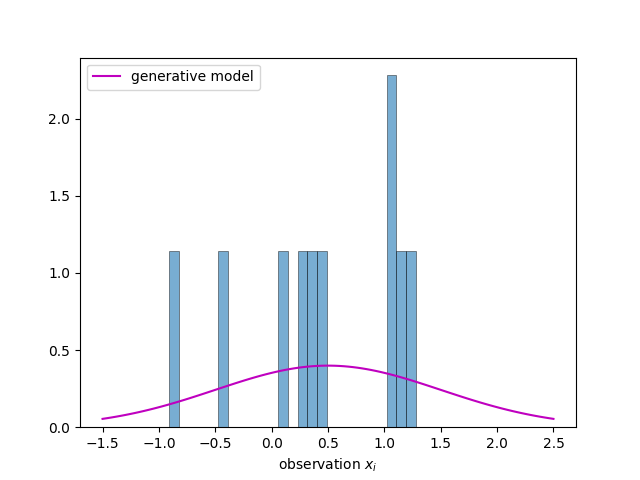

Text(0.5,0,'observation $x_i$')

In [64]:
plt.figure()
plt.hist(D, edgecolor="k", linewidth=0.5, color=["C0"], normed=True, alpha=0.6, histtype="bar", bins=25)
x = np.linspace(0.5-2, 0.5+2, 100)
y = ss.norm.pdf(x, mu_t, np.sqrt(sigma_t))
plt.plot(x,y, "-", color="m", label="generative model")
plt.legend()
plt.xlabel("observation $x_i$")

# Prior and Likelihood

We are interested in the probability distribution of the model parameter $\theta=\mu$ given our observed data, thus with Bayes' Theorem we can write

$p(\theta|D) \propto p(D|\theta) \cdot p(\theta).$

With the assumption of indentically and independently distributed (i.i.d.) drawn samples, the likelihood $p(D|\theta)$ can be written as the product of the likelihoods for each datum: $p(D|\theta) = \prod_{i=1}^N p(x_i|\theta) = \prod_{i=1}^N \mathcal{N}(x_i|\mu, \sigma^2)$.

The prior represents our initial belief about the values $\theta=\mu$ might take. We will analyse the following three priors that represent very different initial belief sets.

$p(\theta) = \mathcal{N}(\theta|\mu_0, \sigma_0)$, with $\mu_0 = 0, \sigma_0^2 = 0.2$

<IPython.core.display.Javascript object>


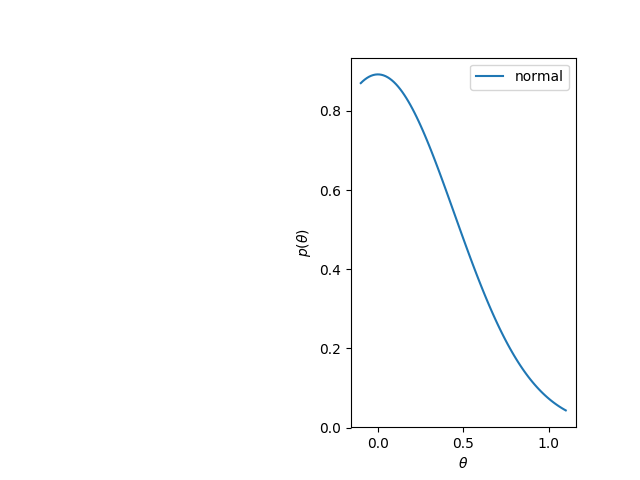

In [50]:
plt.figure()

# normal distributed prior
plt.subplot(1,2,2)
x = np.linspace(-0.1, 1.1, 100)
y = ss.norm.pdf(x, mu_0, np.sqrt(sigma_0))
plt.plot(x,y, label="normal")
plt.xlabel(r"$\theta$")
plt.ylabel(r"$p(\theta)$")
plt.legend(loc="upper right")

# Posterior

Now we look at the posterior. For each of the three priors, we can analytically calculate the posterior. Lets do this:

$\begin{align}
p(\theta=\mu|D) \propto p(D|\theta) \cdot p_1(\theta) &= \prod_{i=1}^N \mathcal{N}(\mu, \sigma^2) \cdot 1 = \prod_{i=1}^N \mathcal{N}(\mu, \sigma^2) = \mathcal{N}(\mu_N, \sigma^2_N), \mu_N = \mu, \sigma^2_N = \cfrac{1}{N}\sigma^2 \\
p(\theta=\mu|D) \propto p(D|\theta) \cdot p_2(\theta) &= \prod_{i=1}^N \mathcal{N}(\mu, \sigma^2) \cdot \mathcal{N}(\mu_0, \sigma^2_0) = \mathcal{N}(\mu_N, \sigma^2_N), \mu_N = \cfrac{1}{N\sigma_0^2 + \sigma^2} \cdot (\sigma^2\mu_0 + N\sigma_0^2\mu), \sigma^2_N = \cfrac{\sigma^2\sigma^2_0}{N\sigma^2_0 + \sigma^2} \\
\end{align}
$

In [73]:
mu_post = 1 / (N * sigma_0 + sigma_t) * (sigma_t * mu_0 + N * sigma_0 * mu_t)
sigma_post = (sigma_t * sigma_0) / (N * sigma_0 + sigma_t)
posterior = lambda x: ss.norm.pdf(x, 1 / (N * sigma_0 + sigma_t) * (sigma_t * mu_0 + N * sigma_0 * mu_t), np.sqrt((sigma_t * sigma_0) / (N * sigma_0 + sigma_t)))

<IPython.core.display.Javascript object>


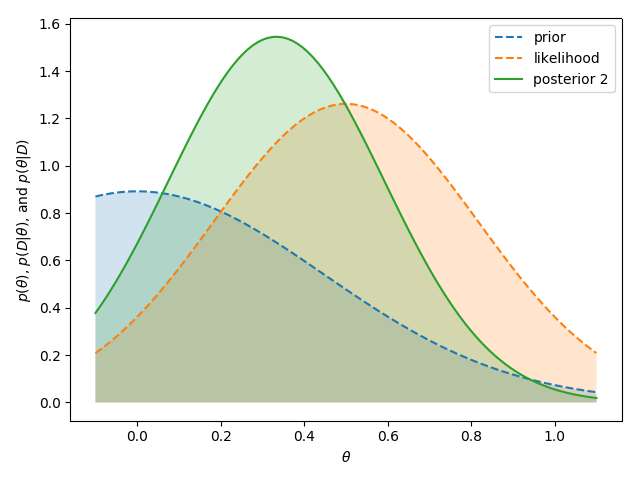

In [70]:
plt.figure()

# normal distributed prior
x = np.linspace(-0.1, 1.1, 100)
y = ss.norm.pdf(x, mu_0, np.sqrt(sigma_0))
plt.fill_between(x, y1=y, y2=0, alpha=0.2)
plt.plot(x,y, "--", label="prior")

y = ss.norm.pdf(x, mu_t, np.sqrt(1/N * sigma_t))
plt.fill_between(x, y1=y, y2=0, alpha=0.2)
plt.plot(x,y, "--", label="likelihood")

y = posterior(x)
plt.fill_between(x, y1=y, y2=0, alpha=0.2)
plt.plot(x,y, label="posterior 2")

plt.xlabel(r"$\theta$")
plt.ylabel(r"$p(\theta)$, $p(D|\theta)$, and $p(\theta|D)$")
plt.legend(loc="upper right")


plt.tight_layout()

# ABC

In [55]:
prior = pyabc.Prior("normal", mu_0, np.sqrt(sigma_0), name=r"$\mu$")

In [56]:
def simulator_mu(mu):
    return ss.norm(loc=mu, scale=np.sqrt(sigma_t)).rvs(N)

In [57]:
def mean(x):
    return np.mean(x)

def var(x):
    return np.var(x)

## Show correctness for three classical ABC sampler

In [65]:
rej = pyabc.RejectionSampler(priors=prior, simulator=simulator_mu, summaries=[mean], observation=D)
mcmc = pyabc.MCMCSampler(priors=prior, simulator=simulator_mu, summaries=[mean], observation=D)
smc = pyabc.SMCSampler(priors=prior, simulator=simulator_mu, summaries=[mean], observation=D)

In [75]:
rej.sample(nr_samples=2000, threshold=0.03)

Rejection sampler started with threshold: 0.03 and number of samples: 2000
Samples:   2000 - Threshold: 0.0300 - Iterations:      65000 - Acceptance rate: 0.030769 - Time:    40.88 s


In [76]:
mcmc.sample(nr_samples=2000, threshold=0.03)

MCMC sampler started with threshold: 0.03 and number of samples: 2000
Samples:   2000 - Threshold: 0.0300 - Iterations:      52963 - Acceptance rate: 0.037762 - Time:    47.23 s


In [77]:
smc.sample(nr_samples=2000, thresholds=np.linspace(0.5, 0.03, 3))

SMC sampler started with thresholds: [ 0.5    0.265  0.03 ] and number of samples: 2000
Iteration 0 completed
starting iteration[ 1 ]
Iteration 1 completed
starting iteration[ 2 ]
Iteration 2 completed
Samples:   2000 - Thresholds: 0.03 - Iterations:      61620 - Acceptance rate: 0.032457 - Time:    66.78 s


<IPython.core.display.Javascript object>


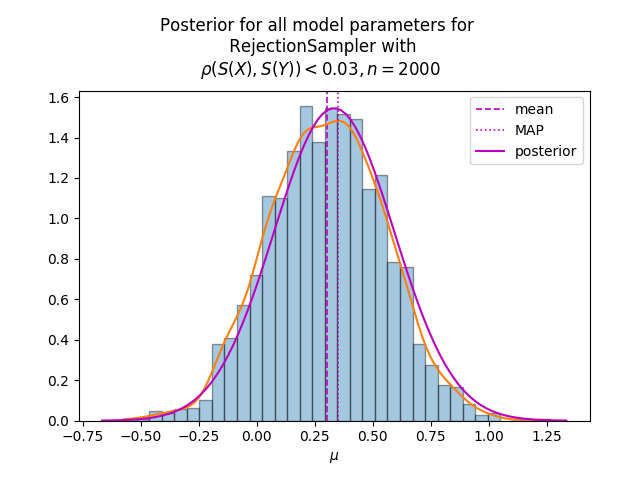

<IPython.core.display.Javascript object>


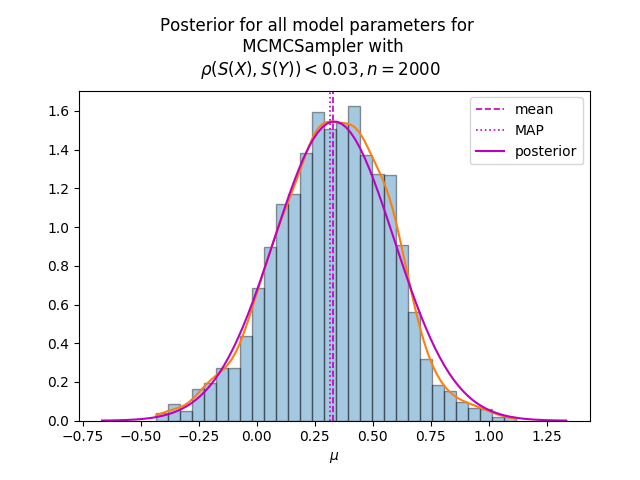

<IPython.core.display.Javascript object>


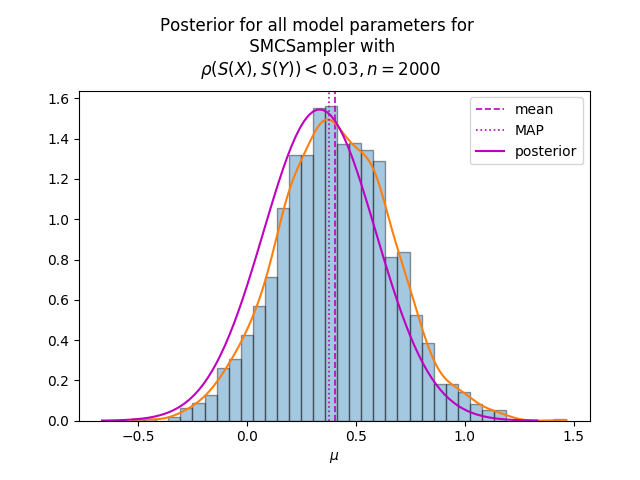

In [78]:
fig = plot_marginals(rej)
x = np.linspace(mu_post-1, mu_post+1, 100)
y = posterior(x)
plt.plot(x, y, "m", label="posterior")
plt.legend()

fig = plot_marginals(mcmc)

y = posterior(x)
plt.plot(x, y, "m", label="posterior")
plt.legend()


fig = plot_marginals(smc)

y = posterior(x)
plt.plot(x, y, "m", label="posterior")
plt.legend()

## Analyze influence of parameter

### Influence of epsilon

Rejection sampler started with threshold: 1 and number of samples: 2000
Samples:   2000 - Threshold: 1.0000 - Iterations:       3000 - Acceptance rate: 0.666667 - Time:     1.78 s


<IPython.core.display.Javascript object>


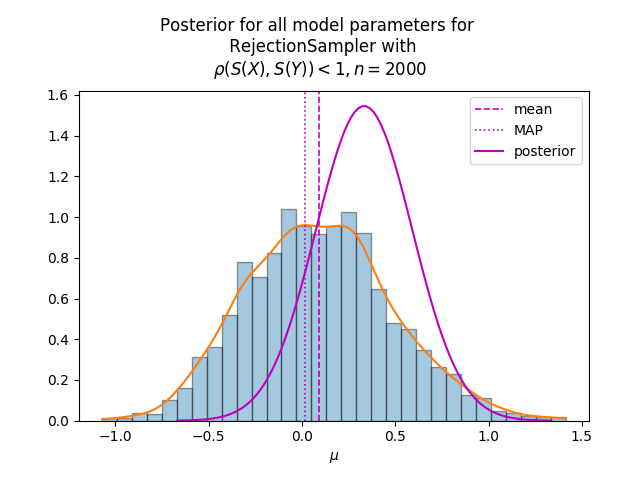

Rejection sampler started with threshold: 0.5 and number of samples: 2000
Samples:   2000 - Threshold: 0.5000 - Iterations:       4000 - Acceptance rate: 0.500000 - Time:     2.53 s


<IPython.core.display.Javascript object>


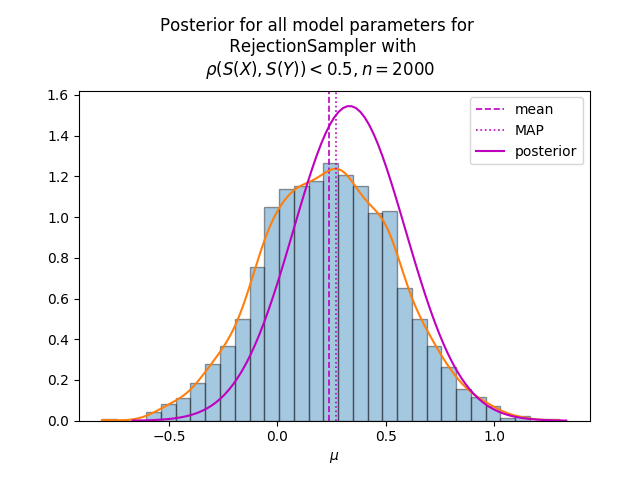

Rejection sampler started with threshold: 0.03 and number of samples: 2000
Samples:   2000 - Threshold: 0.0300 - Iterations:      64000 - Acceptance rate: 0.031250 - Time:    40.59 s


<IPython.core.display.Javascript object>


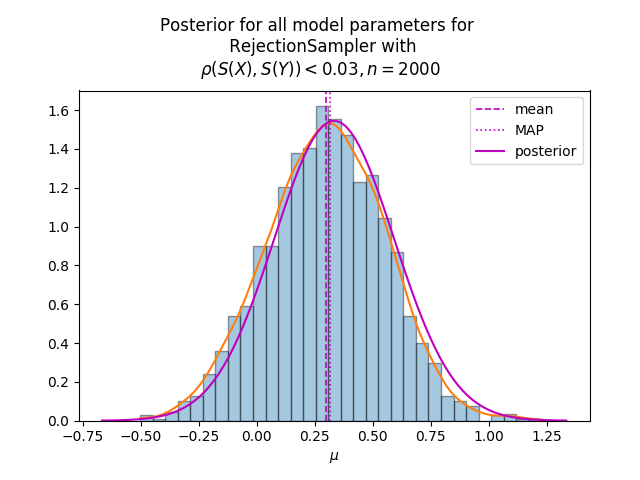

In [80]:
rej.sample(nr_samples=2000, threshold=1)

fig = plot_marginals(rej)

x = np.linspace(mu_post-1, mu_post+1, 100)
y = posterior(x)
plt.plot(x, y, "m", label="posterior")
plt.legend()

rej.sample(nr_samples=2000, threshold=0.5)

fig = plot_marginals(rej)

x = np.linspace(mu_post-1, mu_post+1, 100)
y = posterior(x)
plt.plot(x, y, "m", label="posterior")
plt.legend()

rej.sample(nr_samples=2000, threshold=0.03)

fig = plot_marginals(rej)

x = np.linspace(mu_post-1, mu_post+1, 100)
y = posterior(x)
plt.plot(x, y, "m", label="posterior")
plt.legend()



### Influence of samples

Rejection sampler started with threshold: 1 and number of samples: 100
Samples:    100 - Threshold: 1.0000 - Iterations:       1000 - Acceptance rate: 0.100000 - Time:     0.60 s


<IPython.core.display.Javascript object>


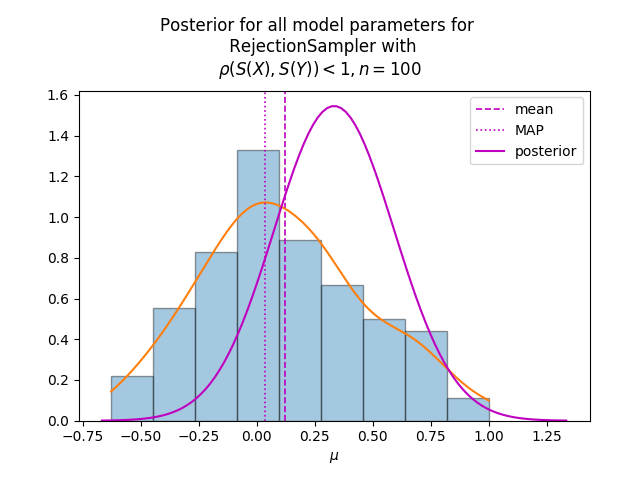

Rejection sampler started with threshold: 0.03 and number of samples: 1000
Samples:   1000 - Threshold: 0.0300 - Iterations:      33000 - Acceptance rate: 0.030303 - Time:    20.74 s


<IPython.core.display.Javascript object>


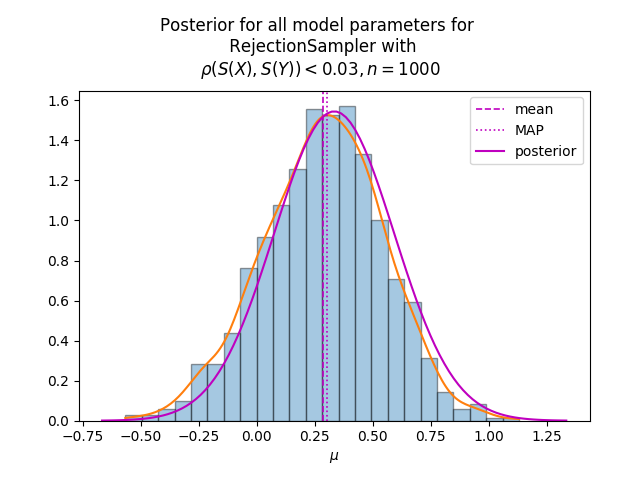

Rejection sampler started with threshold: 0.03 and number of samples: 10000
Samples:  10000 - Threshold: 0.0300 - Iterations:     319000 - Acceptance rate: 0.031348 - Time:   239.70 s


<IPython.core.display.Javascript object>


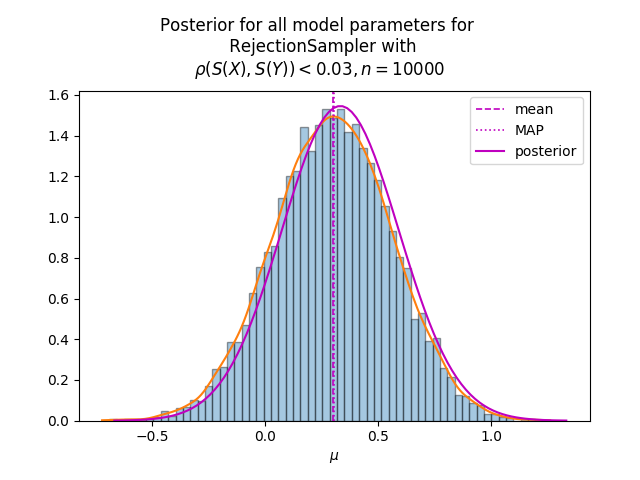

In [81]:
rej.sample(nr_samples=100, threshold=1)

fig = plot_marginals(rej)

x = np.linspace(mu_post-1, mu_post+1, 100)
y = posterior(x)
plt.plot(x, y, "m", label="posterior")
plt.legend()

rej.sample(nr_samples=1000, threshold=0.03)

fig = plot_marginals(rej)

x = np.linspace(mu_post-1, mu_post+1, 100)
y = posterior(x)
plt.plot(x, y, "m", label="posterior")
plt.legend()

rej.sample(nr_samples=10000, threshold=0.03)

fig = plot_marginals(rej)

x = np.linspace(mu_post-1, mu_post+1, 100)
y = posterior(x)
plt.plot(x, y, "m", label="posterior")
plt.legend()



### Influence of data samples

Rejection sampler started with threshold: 0.03 and number of samples: 2000
Samples:   2000 - Threshold: 0.0300 - Iterations:      62000 - Acceptance rate: 0.032258 - Time:    38.71 s


<IPython.core.display.Javascript object>


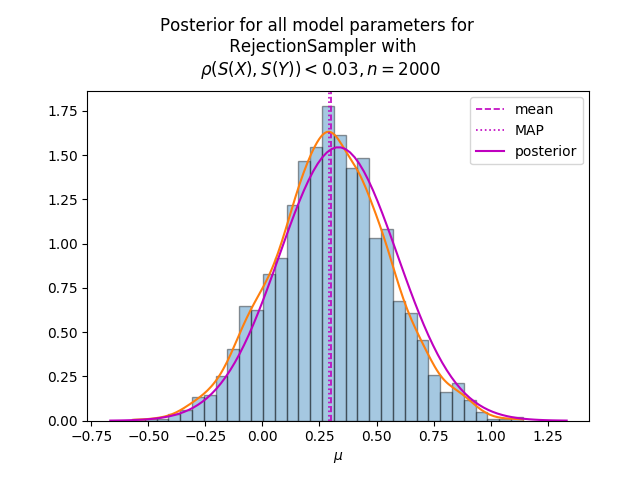

Rejection sampler started with threshold: 0.03 and number of samples: 2000
Samples:   2000 - Threshold: 0.0300 - Iterations:      63000 - Acceptance rate: 0.031746 - Time:    42.30 s


<IPython.core.display.Javascript object>


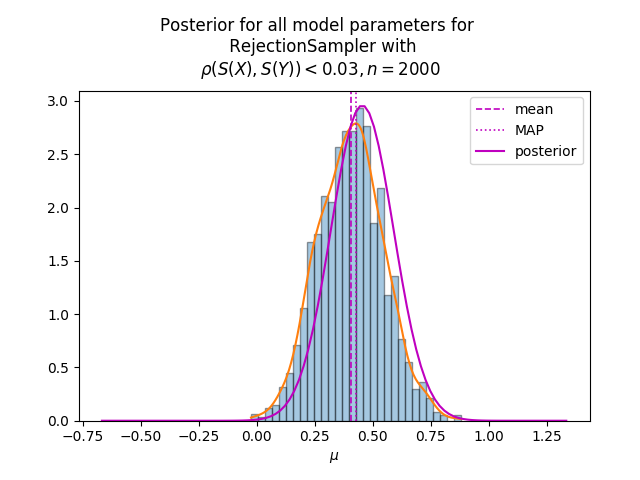

Rejection sampler started with threshold: 0.03 and number of samples: 2000
Samples:   2000 - Threshold: 0.0300 - Iterations:      63000 - Acceptance rate: 0.031746 - Time:    42.73 s


<IPython.core.display.Javascript object>


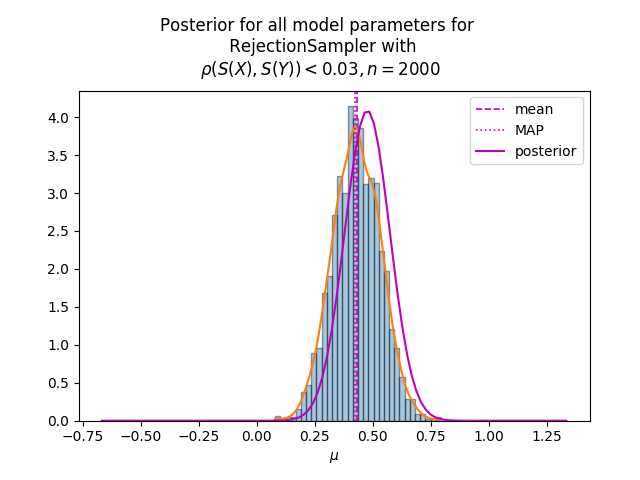

In [82]:
N = 10
D = np.random.normal(mu_t, np.sqrt(sigma_t), N)

rej.sample(nr_samples=2000, threshold=0.03)

fig = plot_marginals(rej)

x = np.linspace(mu_post-1, mu_post+1, 100)
y = posterior(x)
plt.plot(x, y, "m", label="posterior")
plt.legend()

N = 50
D = np.random.normal(mu_t, np.sqrt(sigma_t), N)

rej.sample(nr_samples=2000, threshold=0.03)

fig = plot_marginals(rej)

x = np.linspace(mu_post-1, mu_post+1, 100)
y = posterior(x)
plt.plot(x, y, "m", label="posterior")
plt.legend()

N = 100
D = np.random.normal(mu_t, np.sqrt(sigma_t), N)

rej.sample(nr_samples=2000, threshold=0.03)

fig = plot_marginals(rej)

x = np.linspace(mu_post-1, mu_post+1, 100)
y = posterior(x)
plt.plot(x, y, "m", label="posterior")
plt.legend()

### Influence of summary statistics

Rejection sampler started with threshold: 0.03 and number of samples: 2000
Samples:   2000 - Threshold: 0.0300 - Iterations:      62000 - Acceptance rate: 0.032258 - Time:    50.99 s


<IPython.core.display.Javascript object>


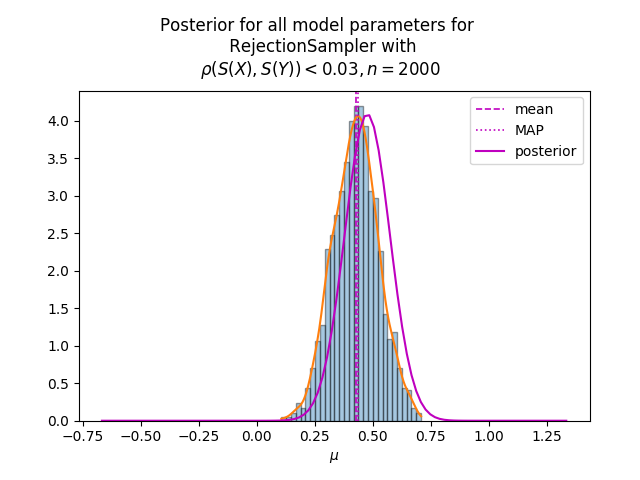

Rejection sampler started with threshold: 0.03 and number of samples: 2000
Samples:   2000 - Threshold: 0.0300 - Iterations:      13000 - Acceptance rate: 0.153846 - Time:    10.78 s


<IPython.core.display.Javascript object>


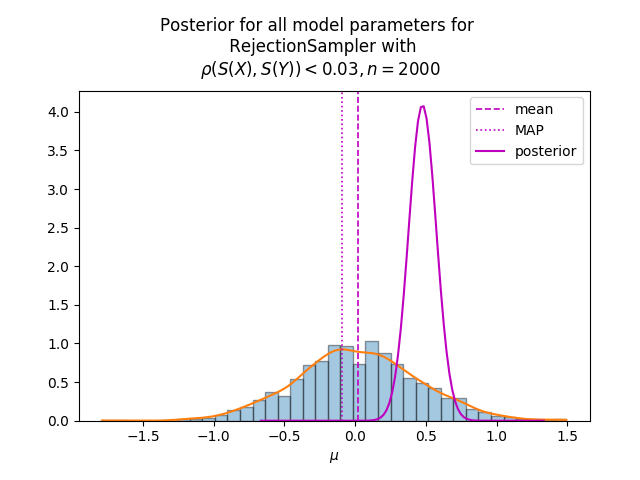

Rejection sampler started with threshold: 0.03 and number of samples: 2000
Samples:   2000 - Threshold: 0.0300 - Iterations:     481000 - Acceptance rate: 0.004158 - Time:   376.35 s


<IPython.core.display.Javascript object>


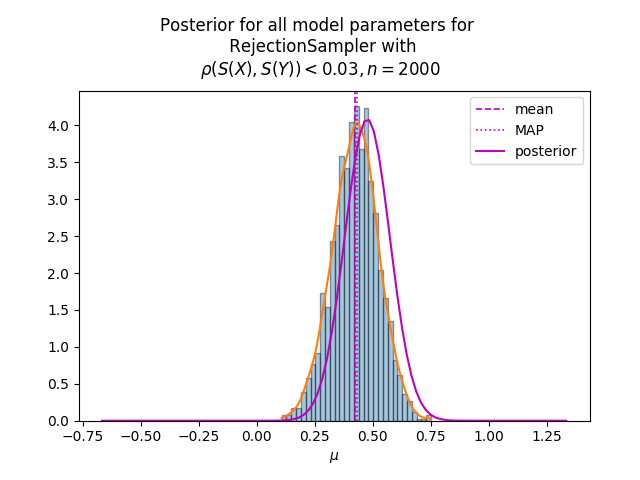

In [84]:
rej = pyabc.RejectionSampler(priors=prior, simulator=simulator_mu, summaries=[mean], observation=D)

rej.sample(nr_samples=2000, threshold=0.03)

fig = plot_marginals(rej)

x = np.linspace(mu_post-1, mu_post+1, 100)
y = posterior(x)
plt.plot(x, y, "m", label="posterior")
plt.legend()

rej = pyabc.RejectionSampler(priors=prior, simulator=simulator_mu, summaries=[var], observation=D)

rej.sample(nr_samples=2000, threshold=0.03)

fig = plot_marginals(rej)

x = np.linspace(mu_post-1, mu_post+1, 100)
y = posterior(x)
plt.plot(x, y, "m", label="posterior")
plt.legend()

rej = pyabc.RejectionSampler(priors=prior, simulator=simulator_mu, summaries=[mean, var], observation=D)

rej.sample(nr_samples=2000, threshold=0.03)

fig = plot_marginals(rej)

x = np.linspace(mu_post-1, mu_post+1, 100)
y = posterior(x)
plt.plot(x, y, "m", label="posterior")
plt.legend()